# Workflow for generating and detecting the most synergistic and redundant module in a big system 

#### 1.- Generation of the system
A system of 100 variables will be generated composed of a strong and a weak synergistic module and a strong and a weak redundant subsystem. The subsystems will be composed of k=20 variables, and one variables can belong only to one of the subsystems. Otherwise, it is independent from the rest. The synergy and redundancy dominated subsystems will be created using PGM (head-to-head and tail-to-tail, respectively) with a Normal distribution and a parameter alpha that controlls synergy and redundancy. The whole system will be created by defining a covariance matrix which is block diagonal, and each block corresponds to the covariance matrix of one of the subsystems (or just diagonal, in the case of the independent variables).


#### 2.- Detection of maximally synergistic and maximally redundant subsystems 
The performance of optimization algorithms to detect the maximally synergistic and redundant subsystem will be evaluated using data generated using the aforementioned covariance matrx. Greedy and simulated annealing algorithms will be used and the identity of the detected subsystem will be compaWeak Redith the indentity of the ground truth.




- **Tail-to-tail system (TT)**: Redundancy dominated. Y is an input to every X in the system. An alpha parameter controlls the effect of Y over X. Then, all the X are conditionally independent
- **Heaad-to-head system (HH)**: Synergy dominated. Every X is an input to Y. An alpha parameter controls the effect of all the X over Y. Then, all the X are marginally independent.


<img src="hh_tt_system.png" width="400px">


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import block_diag
from scipy.stats import zscore
from tqdm import trange

# Import THOI library functions
from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
from thoi.heuristics import simulated_annealing, greedy

# Set plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [2]:
# Generating the covariance matrix for the tail-tail and head-head systems assuming gaussianity (0,1)
def tail_to_tail_cov_matrix(n, alpha):
    # Variance of X_i
    var_X_i = alpha**2 + 1
    # Covariance between X_i and X_j
    cov_X_i_X_j = alpha**2
    # Covariance between X_i and Y
    cov_X_i_Y = alpha
    # Variance of Y
    var_Y = 1

    # Create the covariance matrix
    Sigma_tt = np.full((n + 1, n + 1), cov_X_i_X_j)
    np.fill_diagonal(Sigma_tt, var_X_i)

    # Covariance between X_i and Y
    Sigma_tt[:n, n] = cov_X_i_Y
    Sigma_tt[n, :n] = cov_X_i_Y

    # Variance of Y
    Sigma_tt[n, n] = var_Y

    return Sigma_tt

def head_to_head_cov_matrix(n, alpha):
    # Variance of X_i
    var_X_i = 1
    # Covariance between X_i and Y
    cov_X_i_Y = alpha
    # Variance of Y
    var_Y = n * alpha**2 + 1

    # Create the covariance matrix
    Sigma = np.zeros((n + 1, n + 1))

    # Fill diagonal for X_i variances
    np.fill_diagonal(Sigma[:n, :n], var_X_i)

    # Fill covariances between X_i and Y
    Sigma[:n, -1] = cov_X_i_Y
    Sigma[-1, :n] = cov_X_i_Y

    # Fill variance of Y
    Sigma[-1, -1] = var_Y

    return Sigma



In [3]:
# Auxilirary functions

# List of ids to positional binary hot encoding
def ids2binary(ids, N):
    binary_matrix = np.zeros((N), dtype=bool)
    binary_matrix[ids] = True

    return binary_matrix

# Covariance matrix to correlation matrix 
def cov2corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation
    


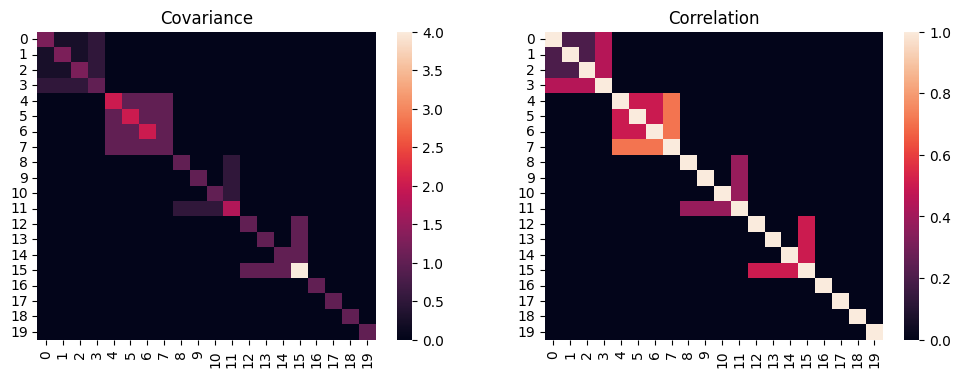

In [4]:
# Creating the system
n = 3 # + 1 = 4 variables in the system
alphas = [0.5, 1.0]
C_tt = [tail_to_tail_cov_matrix(n, alpha) for alpha in alphas]
C_hh = [head_to_head_cov_matrix(n, alpha) for alpha in alphas]
C_indep = np.eye(n+1)
C_joint = block_diag(C_tt[0], C_tt[1], C_hh[0], C_hh[1], C_indep)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(C_joint)
plt.title('Covariance')

plt.subplot(1,2,2)
sns.heatmap(cov2corr(C_joint))
plt.title('Correlation')

plt.show()


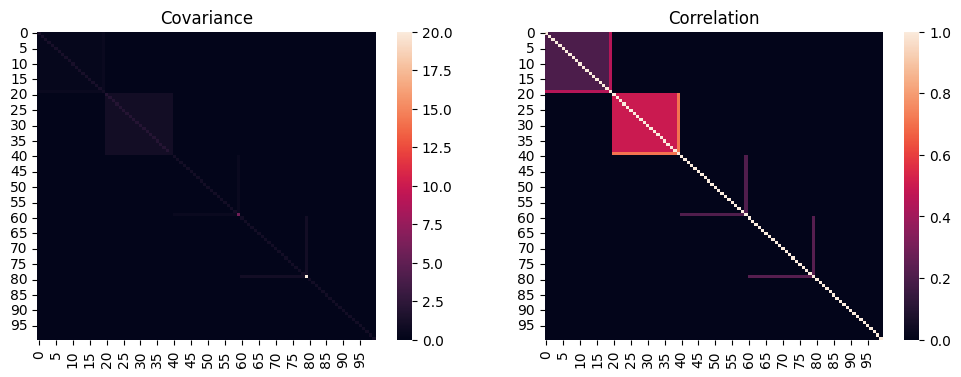

In [5]:
# Creating the system
n = 19 # + 1 = 20 variables in the system
alphas = [0.5, 1.0]
C_tt = [tail_to_tail_cov_matrix(n, alpha) for alpha in alphas]
C_hh = [head_to_head_cov_matrix(n, alpha) for alpha in alphas]
C_indep = np.eye(n+1)
C_joint = block_diag(C_tt[0], C_tt[1], C_hh[0], C_hh[1], C_indep)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(C_joint)
plt.title('Covariance')

plt.subplot(1,2,2)
sns.heatmap(cov2corr(C_joint))
plt.title('Correlation')

plt.show()


In [6]:
# Computing exhaustively all the HOI for each subsystem to validate that there is no other subsystem with higher synergy or redundancy
# Using simulated data to leverage multi_order_measures function
T = 100000
N = n + 1

# Ground truth computed separately as not all datasets have same size
O_tt_full_gt = [nplets_measures(S, covmat_precomputed=True)[0,0,2].numpy()  for S in C_tt]
O_hh_full_gt = [nplets_measures(S, covmat_precomputed=True)[0,0,2].numpy()  for S in C_hh]

X_tt = [np.random.multivariate_normal(np.zeros(N), S, size=T) for S in C_tt]
X_hh = [np.random.multivariate_normal(np.zeros(N), S, size=T) for S in C_hh]

measures_tt = [multi_order_measures(x) for x in X_tt]
measures_hh = [multi_order_measures(x) for x in X_hh] 

O_tt_max = [x['o'].max() for x in measures_tt]
O_hh_max = [x['o'].max() for x in measures_hh]
O_tt_min = [x['o'].min() for x in measures_tt]
O_hh_min = [x['o'].min() for x in measures_hh]

O_tt_full_est = [x['o'].iloc[-1] for x in measures_tt]
O_hh_full_est = [x['o'].iloc[-1] for x in measures_hh]


# Results
print('Ground truth')
print('Tail-to-tail')
print(f'Max alpha 0.5: {O_tt_max[0]}, Max alpha 1.0: {O_tt_max[1]}')
print(f'Min alpha 0.5: {O_tt_min[0]}, Min alpha 1.0: {O_tt_min[1]}')
print(f'Full estimated alpha 0.5: {O_tt_full_est[0]}, Full estimated alpha 1.0: {O_tt_full_est[1]}')
print(f'Full ground truth alpha 0.5: {O_tt_full_gt[0]}, Full ground truth alpha 1.0: {O_tt_full_gt[1]}')

print('Head-to-head')
print(f'Max alpha 0.5: {O_hh_max[0]}, Max alpha 1.0: {O_hh_max[1]}')
print(f'Min alpha 0.5: {O_hh_min[0]}, Min alpha 1.0: {O_hh_min[1]}')
print(f'Full estimated alpha 0.5: {O_hh_full_est[0]}, Full estimated alpha 1.0: {O_hh_full_est[1]}')
print(f'Full ground truth alpha 0.5: {O_hh_full_gt[0]}, Full ground truth alpha 1.0: {O_hh_full_gt[1]}')

Ground truth
Tail-to-tail
Max alpha 0.5: 1.2500266337802195, Max alpha 1.0: 5.0974855781110975
Min alpha 0.5: 0.005917042286055718, Min alpha 1.0: 0.08306432571724098
Full estimated alpha 0.5: 1.2500266337802195, Full estimated alpha 1.0: 5.0974855781110975
Full ground truth alpha 0.5: 1.2452842333596834, Full ground truth alpha 1.0: 5.087052501821844
Head-to-head
Max alpha 0.5: 1.923669315218035e-05, Max alpha 1.0: 2.0144160917112686e-05
Min alpha 0.5: -1.2281230976041044, Min alpha 1.0: -5.095967601002517
Full estimated alpha 0.5: -1.2281230976041044, Full estimated alpha 1.0: -5.095967601002517
Full ground truth alpha 0.5: -1.2452433868009223, Full ground truth alpha 1.0: -5.087011655263151


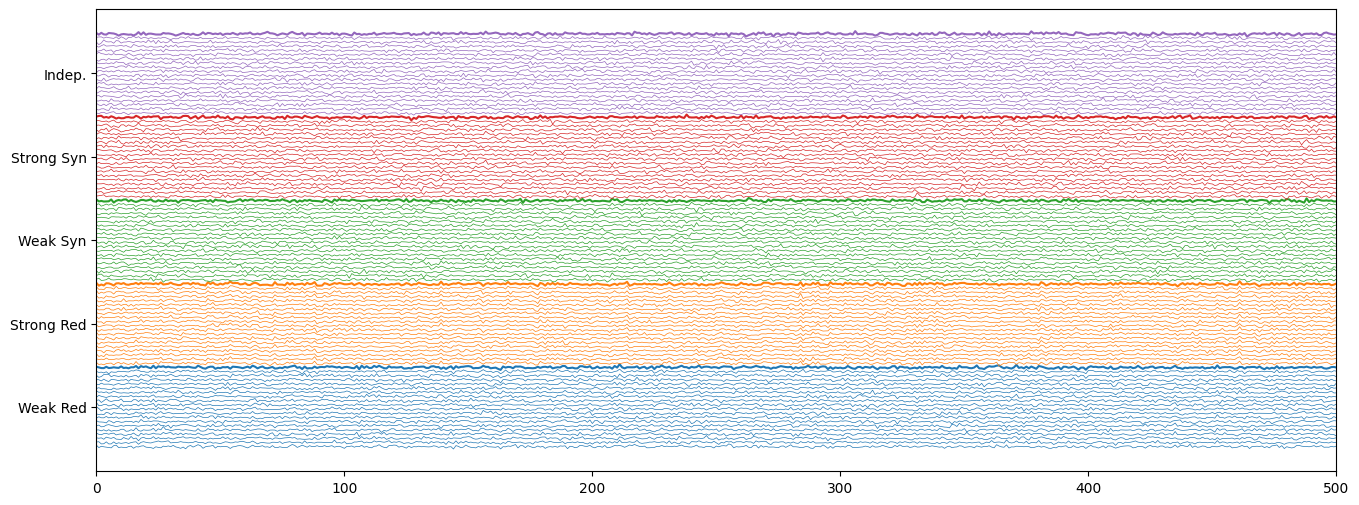

: 

In [ ]:
# Generating data with the covariance matrix
T = 100000
N = len(C_joint)
X = np.random.multivariate_normal(np.zeros(N), C_joint, size=T)

offset = 5
xlim = 500
yticks = np.arange(((n)*offset)/2, (N+1)*offset+1, (n+1)*offset)
yticklabels = ['Weak Red', 'Strong Red', 'Weak Syn', 'Strong Syn', 'Indep.']

colors = sns.color_palette("tab10", n_colors=5)
colors = [color for color in colors for _ in range(n+1)]
plt.figure(figsize=(16,6))
for i in range(X.shape[1]):
    if (i+1)%(n+1)==0:
        plt.plot(zscore(X[:, i]) + i*offset, color=colors[i], linewidth=1.5)
    else:
        plt.plot(zscore(X[:, i]) + i*offset, color=colors[i], linewidth=0.5)
        
plt.xlim([0,xlim])
plt.yticks(yticks, labels=yticklabels)
plt.show()

## Optimization with Greedy

In [ ]:
# Running greedy
# It took 2h 20m for N=100
max_k = len(C_joint)
min_k = 3
norders = max_k - min_k +1

g_repeat = 10000
# Maximize
greedy_out_max = greedy(X, min_k, max_k, repeat=g_repeat, metric='o', largest=True, batch_size=10000)
# Minimize
greedy_out_min = greedy(X, min_k, max_k, repeat=g_repeat, metric='o', largest=False, batch_size=10000)

# Extracting max per order
g_max_scores = np.vstack(greedy_out_max[1])
g_max_vals_k = np.max(g_max_scores,axis=0)
g_max_id = np.argmax(g_max_scores,axis=0)
g_best_max_part_k = greedy_out_max[0][g_max_id]
g_best_max_part_k = [np.sort(g_best_max_part_k[k,:(min_k+k)]) for k in range(0, norders)] 
# Extracting min per order
g_min_scores = np.vstack(greedy_out_min[1])
g_min_vals_k = np.min(g_min_scores,axis=0)
g_min_id = np.argmin(g_min_scores,axis=0)
g_best_min_part_k = greedy_out_min[0][g_min_id]
g_best_min_part_k = [np.sort(g_best_min_part_k[k,:(min_k+k)]) for k in range(0, norders)] 

# Converting selected variables into colored matrices
g_best_max_part_k_mat = np.vstack([ids2binary(x, N) for x in g_best_max_part_k])*1.0
g_best_min_part_k_mat = np.vstack([ids2binary(x, N) for x in g_best_min_part_k])*1.0
for i in range(N):
    g_best_max_part_k_mat[:, i] = (g_best_max_part_k_mat[:, i] != 0) * (i // (n+1) + 1)
    g_best_min_part_k_mat[:, i] = (g_best_min_part_k_mat[:, i] != 0) * (i // (n+1) + 1)

Order:  71%|███████   | 69/97 [2:52:37<2:59:22, 384.39s/it]

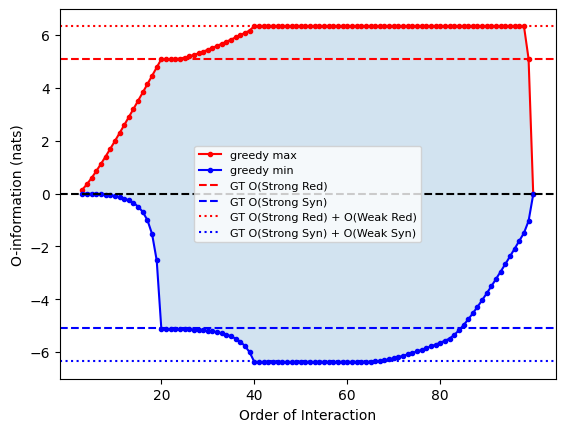

In [ ]:
# Plotting greedy results

xx = np.arange(min_k,max_k+1)
N = len(C_joint)
plt.figure()
plt.plot(xx,g_max_vals_k, 'r.-', label='greedy max')
plt.plot(xx,g_min_vals_k, 'b.-', label='greedy min')
plt.fill_between(xx, g_min_vals_k, g_max_vals_k, alpha=0.2)


plt.axhline(y=0,color='k', linestyle='--')
plt.axhline(y=O_tt_full_gt[1],color='r', linestyle='--', label='GT O(Strong Red)')
plt.axhline(y=O_hh_full_gt[1],color='b', linestyle='--', label='GT O(Strong Syn)')
plt.axhline(y=np.sum(O_tt_full_gt), color='r', linestyle=':', label='GT O(Strong Red) + O(Weak Red)')
plt.axhline(y=np.sum(O_hh_full_gt), color='b', linestyle=':', label='GT O(Strong Syn) + O(Weak Syn)')
plt.ylabel('O-information (nats)')
plt.xlabel('Order of Interaction')
plt.legend(fontsize=8, loc='center')
plt.xticks(np.arange(n+1, N, n+1))

plt.show()



## Optimization with Annealing

In [ ]:
# Running annealing
max_k = len(C_joint)
min_k = 3
norders = max_k - min_k +1

sa_repeat = 100
sa_max_vals_k = np.zeros((norders))
sa_min_vals_k = np.zeros((norders))
sa_best_max_part_k = list()
sa_best_min_part_k = list()

for k in trange(min_k,max_k, desc='Order'):

    # Maximizing
    sa_out_max = simulated_annealing(X, order=k, repeat=sa_repeat, metric='o', largest=True)
    max_scores = np.vstack(sa_out_max[1])
    sa_max_vals_k[k-min_k] = np.squeeze(np.max(max_scores))
    max_vals_k_id = np.squeeze(np.argmax(max_scores))
    sa_best_max_part_k.append(sa_out_max[0][max_vals_k_id])
    
    # Minimizing
    sa_out_min = simulated_annealing(X, order=k, repeat=sa_repeat, metric='o', largest=False)
    min_scores = np.vstack(sa_out_min[1])
    sa_min_vals_k[k-min_k] = np.squeeze(np.min(min_scores))
    min_vals_k_id = np.squeeze(np.argmin(min_scores))
    sa_best_min_part_k.append(sa_out_min[0][min_vals_k_id])

# Converting selected variables into colored matrix
sa_best_max_part_k_mat = np.vstack([ids2binary(x, N) for x in sa_best_max_part_k])*1.0
sa_best_min_part_k_mat = np.vstack([ids2binary(x, N) for x in sa_best_min_part_k])*1.0

# Adding last row to SA
sa_best_max_part_k_mat = np.vstack((sa_best_max_part_k_mat, np.ones(N)))
sa_best_min_part_k_mat = np.vstack((sa_best_min_part_k_mat, np.ones(N)))
for i in range(N):
    sa_best_max_part_k_mat[:, i] = (sa_best_max_part_k_mat[:, i] != 0) * (i // (n+1) + 1)
    sa_best_min_part_k_mat[:, i] = (sa_best_min_part_k_mat[:, i] != 0) * (i // (n+1) + 1)

Order: 3
Maximizing


Minimizing


Order: 4
Maximizing


Minimizing


Order: 5
Maximizing


Minimizing


Order: 6
Maximizing


Minimizing


Order: 7
Maximizing


Minimizing


Order: 8
Maximizing


Minimizing


Order: 9
Maximizing


Minimizing


Order: 10
Maximizing


Minimizing


Order: 11
Maximizing


Minimizing


Order: 12
Maximizing


Minimizing


Order: 13
Maximizing


Minimizing


Order: 14
Maximizing


Minimizing


Order: 15
Maximizing


Minimizing


Order: 16
Maximizing


Minimizing


Order: 17
Maximizing


Minimizing


Order: 18
Maximizing


Minimizing


Order: 19
Maximizing


Minimizing


Order: 20
Maximizing


Minimizing


Order: 21
Maximizing


Minimizing


Order: 22
Maximizing


Minimizing


Order: 23
Maximizing


Minimizing


Order: 24
Maximizing


Minimizing


Order: 25
Maximizing


Minimizing


Order: 26
Maximizing


Minimizing


Order: 27
Maximizing


Minimizing


Order: 28
Maximizing


Minimizing


Order: 29
Maximizing


Minimizing


Order: 30
Maximizing


Minimizing


Order: 31
Maximizing


Minimizing


Order: 32
Maximizing


Minimizing


Order: 33
Maximizing


Minimizing


Order: 34
Maximizing


Minimizing


Order: 35
Maximizing


Minimizing


Order: 36
Maximizing


Minimizing


Order: 37
Maximizing


Minimizing


Order: 38
Maximizing


Minimizing


Order: 39
Maximizing


Minimizing


Order: 40
Maximizing


Minimizing


Order: 41
Maximizing


Minimizing


Order: 42
Maximizing


Minimizing


Order: 43
Maximizing


Minimizing


Order: 44
Maximizing


Minimizing


Order: 45
Maximizing


Minimizing


Order: 46
Maximizing


Minimizing


Order: 47
Maximizing


Minimizing


Order: 48
Maximizing


Minimizing


Order: 49
Maximizing


Minimizing


Order: 50
Maximizing


Minimizing


Order: 51
Maximizing


Minimizing


Order: 52
Maximizing


Minimizing


Order: 53
Maximizing


Minimizing


Order: 54
Maximizing


Minimizing


Order: 55
Maximizing


Minimizing


Order: 56
Maximizing


Minimizing


Order: 57
Maximizing


Minimizing


Order: 58
Maximizing


Minimizing


Order: 59
Maximizing


Minimizing


Order: 60
Maximizing


Minimizing


Order: 61
Maximizing


Minimizing


Order: 62
Maximizing


Minimizing


Order: 63
Maximizing


Minimizing


Order: 64
Maximizing


Minimizing


Order: 65
Maximizing


Minimizing


Order: 66
Maximizing


Minimizing


Order: 67
Maximizing


Minimizing


Order: 68
Maximizing


Minimizing


Order: 69
Maximizing


Minimizing


Order: 70
Maximizing


Minimizing


Order: 71
Maximizing


Minimizing


Order: 72
Maximizing


Minimizing


Order: 73
Maximizing


Minimizing


Order: 74
Maximizing


Minimizing


Order: 75
Maximizing


Minimizing


Order: 76
Maximizing


Minimizing


Order: 77
Maximizing


Minimizing


Order: 78
Maximizing


Minimizing


Order: 79
Maximizing


Minimizing


Order: 80
Maximizing


Minimizing


Order: 81
Maximizing


Minimizing


Order: 82
Maximizing


Minimizing


Order: 83
Maximizing


Minimizing


Order: 84
Maximizing


Minimizing


Order: 85
Maximizing


Minimizing


Order: 86
Maximizing


Minimizing


Order: 87
Maximizing


Minimizing


Order: 88
Maximizing


Minimizing


Order: 89
Maximizing


Minimizing


Order: 90
Maximizing


Minimizing


Order: 91
Maximizing


Minimizing


Order: 92
Maximizing


Minimizing


Order: 93
Maximizing


Minimizing


Order: 94
Maximizing


Minimizing


Order: 95
Maximizing


Minimizing


Order: 96
Maximizing


Minimizing


Order: 97
Maximizing


Minimizing


Early stop reached
Order: 98
Maximizing


Early stop reached
Minimizing


Early stop reached
Order: 99
Maximizing


Early stop reached
Minimizing


Early stop reached


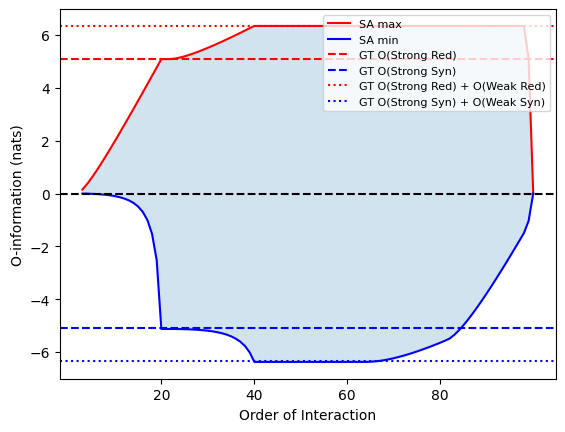

In [ ]:
# Plotting Annealing results

xx = np.arange(min_k,max_k+1)
N = len(C_joint)
plt.figure()
plt.plot(xx,sa_max_vals_k, 'r', label='SA max')
plt.plot(xx,sa_min_vals_k, 'b', label='SA min')
plt.fill_between(xx, sa_min_vals_k, sa_max_vals_k, alpha=0.2)

plt.axhline(y=0,color='k', linestyle='--')
plt.axhline(y=O_tt_full_gt[1],color='r', linestyle='--', label='GT O(Strong Red)')
plt.axhline(y=O_hh_full_gt[1],color='b', linestyle='--', label='GT O(Strong Syn)')
plt.axhline(y=np.sum(O_tt_full_gt), color='r', linestyle=':', label='GT O(Strong Red) + O(Weak Red)')
plt.axhline(y=np.sum(O_hh_full_gt), color='b', linestyle=':', label='GT O(Strong Syn) + O(Weak Syn)')
plt.ylabel('O-information (nats)')
plt.xlabel('Order of Interaction')
plt.legend(fontsize=8, loc='upper right')
plt.xticks(np.arange(n+1, N, n+1))

plt.show()

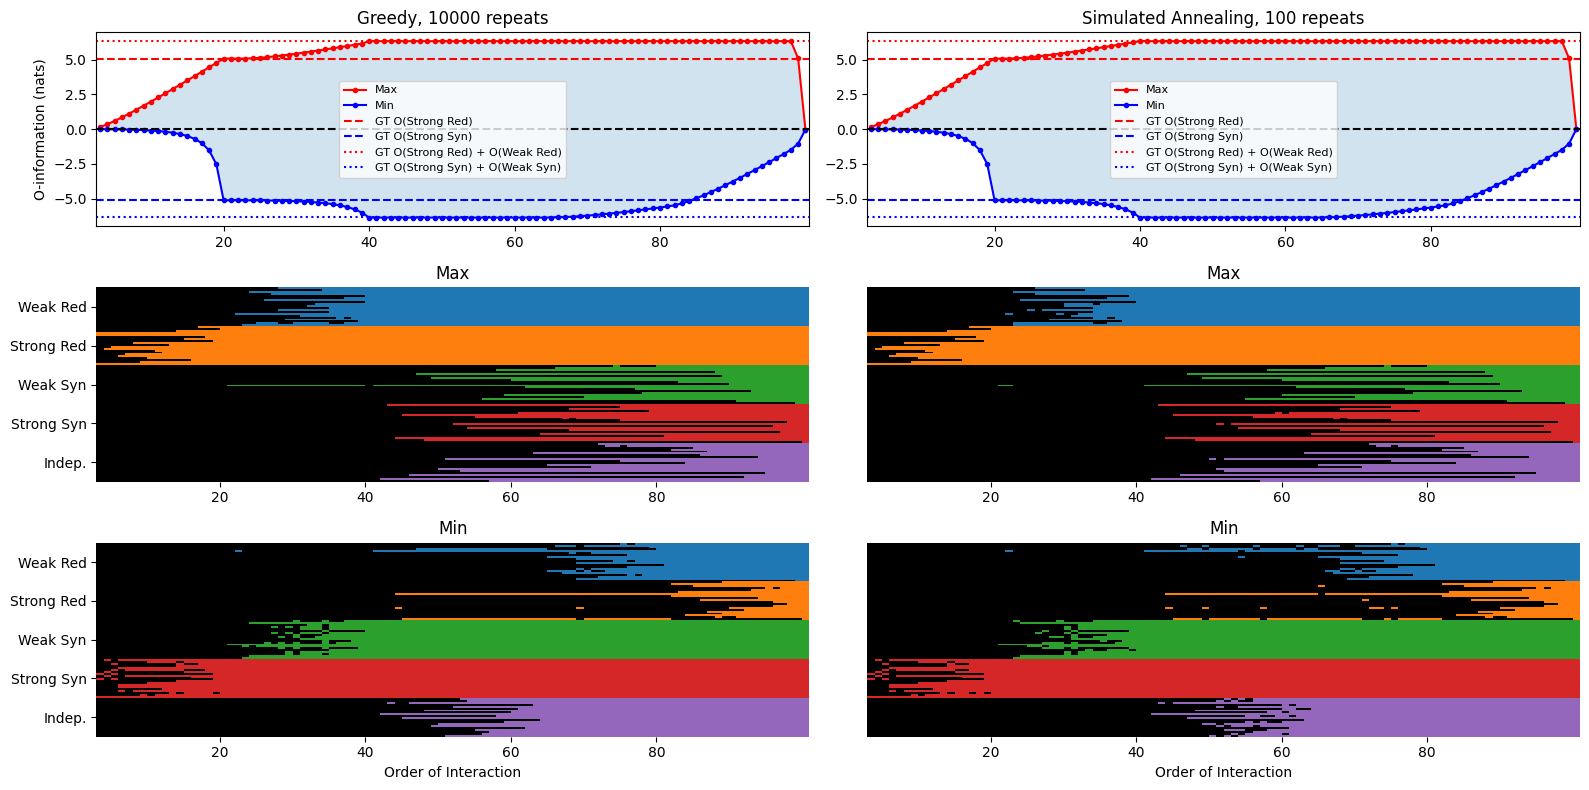

In [ ]:
# Plotting Greedy and SA together
figname = 'greedy_and_SA_vs_N-'+str(N)+'_v1'

N = len(C_joint)
xx = np.arange(min_k,max_k+1)
xx2 = np.arange(n+1, N, n+1)

yticklabels = ['Weak Red', 'Strong Red', 'Weak Syn', 'Strong Syn', 'Indep.']

tick_locs = (np.arange(n+1) + 0.5)*(n)/(n)
colors = sns.color_palette("tab10", n_colors=5, as_cmap=False)
colors = np.vstack([color for color in colors for _ in range(1)])
colors = np.vstack((np.zeros(3),colors))
colors = sns.color_palette(colors)

fig=plt.figure(figsize=(16,8))

plt.subplot(3,2,1)
plt.plot(xx,g_max_vals_k, 'r', marker='.', label='Max')
plt.plot(xx,g_min_vals_k, 'b', marker='.', label='Min')
plt.fill_between(xx, g_min_vals_k, g_max_vals_k, alpha=0.2)

plt.axhline(y=0,color='k', linestyle='--')
plt.axhline(y=O_tt_full_gt[1],color='r', linestyle='--', label='GT O(Strong Red)')
plt.axhline(y=O_hh_full_gt[1],color='b', linestyle='--', label='GT O(Strong Syn)')
plt.axhline(y=np.sum(O_tt_full_gt), color='r', linestyle=':', label='GT O(Strong Red) + O(Weak Red)')
plt.axhline(y=np.sum(O_hh_full_gt), color='b', linestyle=':', label='GT O(Strong Syn) + O(Weak Syn)')
plt.ylabel('O-information (nats)')
# plt.xlabel('Order of Interaction')
plt.legend(fontsize=8, loc='center')
plt.xticks(xx2)
plt.title('Greedy, '+str(g_repeat)+' repeats')
plt.xlim([min_k-0.5,max_k+0.5])

plt.subplot(3,2,2)
plt.plot(xx,sa_max_vals_k, 'r', marker='.', label='Max')
plt.plot(xx,sa_min_vals_k, 'b', marker='.', label='Min')
plt.fill_between(xx, sa_min_vals_k, sa_max_vals_k, alpha=0.2)

plt.axhline(y=0,color='k', linestyle='--')
plt.axhline(y=O_tt_full_gt[1],color='r', linestyle='--', label='GT O(Strong Red)')
plt.axhline(y=O_hh_full_gt[1],color='b', linestyle='--', label='GT O(Strong Syn)')
plt.axhline(y=np.sum(O_tt_full_gt), color='r', linestyle=':', label='GT O(Strong Red) + O(Weak Red)')
plt.axhline(y=np.sum(O_hh_full_gt), color='b', linestyle=':', label='GT O(Strong Syn) + O(Weak Syn)')
# plt.ylabel('O-information (nats)')
# plt.xlabel('Order of Interaction')
plt.legend(fontsize=8, loc='center')
plt.xticks(xx2)
plt.title('Simulated Annealing, '+str(sa_repeat)+' repeats')
plt.xlim([min_k-0.5,max_k+0.5])


plt.subplot(3,2,3)
ax=sns.heatmap(g_best_max_part_k_mat.T, cmap=colors, yticklabels=[], xticklabels=[], cbar=None)
plt.title('Max')
plt.yticks(np.arange((n+1)/2, N, n+1), labels=yticklabels)
plt.xticks(xx2-min_k, labels=xx2)


plt.subplot(3,2,4)
ax=sns.heatmap(sa_best_max_part_k_mat.T, cmap=colors, yticklabels=[], xticklabels=[], cbar=None)
plt.title('Max')
plt.xticks(xx2-min_k, labels=xx2)

plt.subplot(3,2,5)
ax=sns.heatmap(g_best_min_part_k_mat.T, cmap=colors, yticklabels=[], xticklabels=[], cbar=None)
plt.title('Min')
plt.xlabel('Order of Interaction')
plt.yticks(np.arange((n+1)/2, N, n+1), labels=yticklabels)
plt.xticks(xx2-min_k, labels=xx2)


plt.subplot(3,2,6)
ax=sns.heatmap(sa_best_min_part_k_mat.T, cmap=colors, yticklabels=[], xticklabels=[], cbar=None)
plt.title('Min')
plt.xlabel('Order of Interaction')
plt.xticks(xx2-min_k, labels=xx2)
# plt.yticks(np.arange((n+1)/2, N, n+1), labels=yticklabels)


plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')
